<a href="https://colab.research.google.com/github/BhumikaMatharu/Detecting-and-Predicting-Visual-Affordances-of-Objects/blob/main/Affordance_Classifier_Heatmap_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tqdm

     |████████████████████████████████| 75 kB 3.7 MB/s 


In [ ]:
#imports
import keras
from keras.models import Sequential, Model
from keras import applications
from keras import backend as K
from keras.utils import plot_model
from keras.layers.convolutional import Conv2D, MaxPooling2D, MaxPooling3D, AveragePooling3D, Conv3D, Conv3DTranspose, AveragePooling2D
from keras.layers import Dropout, concatenate, Reshape, Input, Flatten, Dense, Activation, Conv2DTranspose, Lambda
from keras.layers import TimeDistributed, LSTM, Input, GlobalAveragePooling2D, LeakyReLU, Softmax, Multiply, RepeatVector
from keras.layers.convolutional_recurrent import ConvLSTM2D
from keras.layers.normalization import BatchNormalization
from keras.applications.vgg16 import preprocess_input
from keras.losses import CategoricalCrossentropy
from tqdm import tqdm
import numpy as np
from keras.utils import np_utils, to_categorical
import pandas as pd
import glob
from os import path
import cv2,copy
from keras.preprocessing import image
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping, LearningRateScheduler
import ast

Using TensorFlow backend.


In [ ]:
# Getting Opra dataset
!wget ftp://cs.stanford.edu/cs/cvgl/OPRA/data.zip
!unzip data.zip

In [ ]:
# VGG16 without top layer
base_model = applications.VGG16(weights='imagenet',include_top = False, input_shape=(128,128,3))
# vgg_model = Model(inputs=base_model.input,outputs=base_model.get_layer('block3_pool').output)
vgg_model = base_model
vgg_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0     

In [ ]:
def aff_model(size):

  # RGB frames
  Input_Spatial = Input(shape=(14,size,size,3), name='cnn-rgb')

  cnn_spatial = TimeDistributed(vgg_model)(Input_Spatial)
  
  encoder_1 = ConvLSTM2D(filters=512,kernel_size=3,strides=(1,1),padding='same',return_sequences=True, return_state=True,activation='relu')

  encoder_outputs_1, encoder_state_h_1, encoder_state_c_1 = encoder_1(cnn_spatial)

  # Motion frames
  Input_Temporal = Input(shape=(14,size,size,3), name='cnn-motion')

  cnn_temporal = TimeDistributed(vgg_model)(Input_Temporal)

  encoder_2 = ConvLSTM2D(filters=512,kernel_size=3,strides=(1,1),padding='same',return_sequences=True, return_state=True,activation='relu')

  encoder_outputs_2, encoder_state_h_2, encoder_state_c_2 = encoder_2(cnn_temporal)
  
  concate_encoders = concatenate([encoder_outputs_1,encoder_outputs_2],axis=-1)

  conv_attn = TimeDistributed(Dense(512))(concate_encoders)

  soft_attn = TimeDistributed(Softmax())(conv_attn)

  multiplied = Multiply()([soft_attn,encoder_outputs_1])

  Lambda_layer=Lambda(lambda x: K.sum(x, axis=1,keepdims=True) )

  summation = Lambda_layer(multiplied)

  sq_layer = Lambda(lambda x: tf.squeeze(x, axis=1))

  summation = sq_layer(summation)

  # Action Classifier

  comb_features = Reshape((-1,summation.shape[1]*summation.shape[2]*summation.shape[3]))(summation)

  sq_layer1 = Lambda(lambda x: tf.squeeze(x, axis=1))

  comb_features = sq_layer1(comb_features)

  lstm_inp = RepeatVector(14)(comb_features)

  classifier = LSTM(512, dropout=0.2)(lstm_inp)

  dense_layer = Dense(3,activation='softmax',name='classification')(classifier)

  # Heatmap Decoder
  
  decoder_inputs = Input(shape=(size,size,3),name='decoder_inp')

  decode_inp_image = vgg_model(decoder_inputs)
  
  concatenate_features = concatenate([decode_inp_image,summation])

  fcn1 = Conv2D(filters = 1024,strides=1,kernel_size=1,padding='same')(concatenate_features)

  fcn2= Conv2D(filters = 1024, strides=1,kernel_size=1,padding='same')(fcn1)

  upscaling = Conv2DTranspose(filters=1,kernel_size=64,strides=32,padding='same')(fcn2)
 
  sq_layer2 = Lambda(lambda x: tf.squeeze(x, axis=-1))

  upscaling = sq_layer2(upscaling)

  outputs = Softmax()(upscaling)

  model = Model([Input_Spatial,Input_Temporal,decoder_inputs],[dense_layer,outputs])

  return model

In [ ]:
model = aff_model(128)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
cnn-rgb (InputLayer)            (None, 14, 128, 128, 0                                            
__________________________________________________________________________________________________
cnn-motion (InputLayer)         (None, 14, 128, 128, 0                                            
__________________________________________________________________________________________________
time_distributed_5 (TimeDistrib (None, 14, 4, 4, 512 14714688    cnn-rgb[0][0]                    
__________________________________________________________________________________________________
time_distributed_6 (TimeDistrib (None, 14, 4, 4, 512 14714688    cnn-motion[0][0]                 
____________________________________________________________________________________________

In [ ]:
# Compiling the model
# loss=keras.losses.KLDivergence(),

# # initial_learning_rate = 0.0001
# def step_decay(epoch):
#    initial_lrate = 0.0001
#    drop = 0.1
#    epochs_drop = 1000.0
#    lrate = initial_lrate * math.pow(drop,  
#            math.floor((1+epoch)/epochs_drop))
#    return lrate
# lrate = LearningRateScheduler(step_decay)

opt = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=opt,
              loss = ['categorical_crossentropy',keras.losses.KLDivergence()],
              metrics=['accuracy','mean_squared_error'])

In [ ]:
!pip install pydot

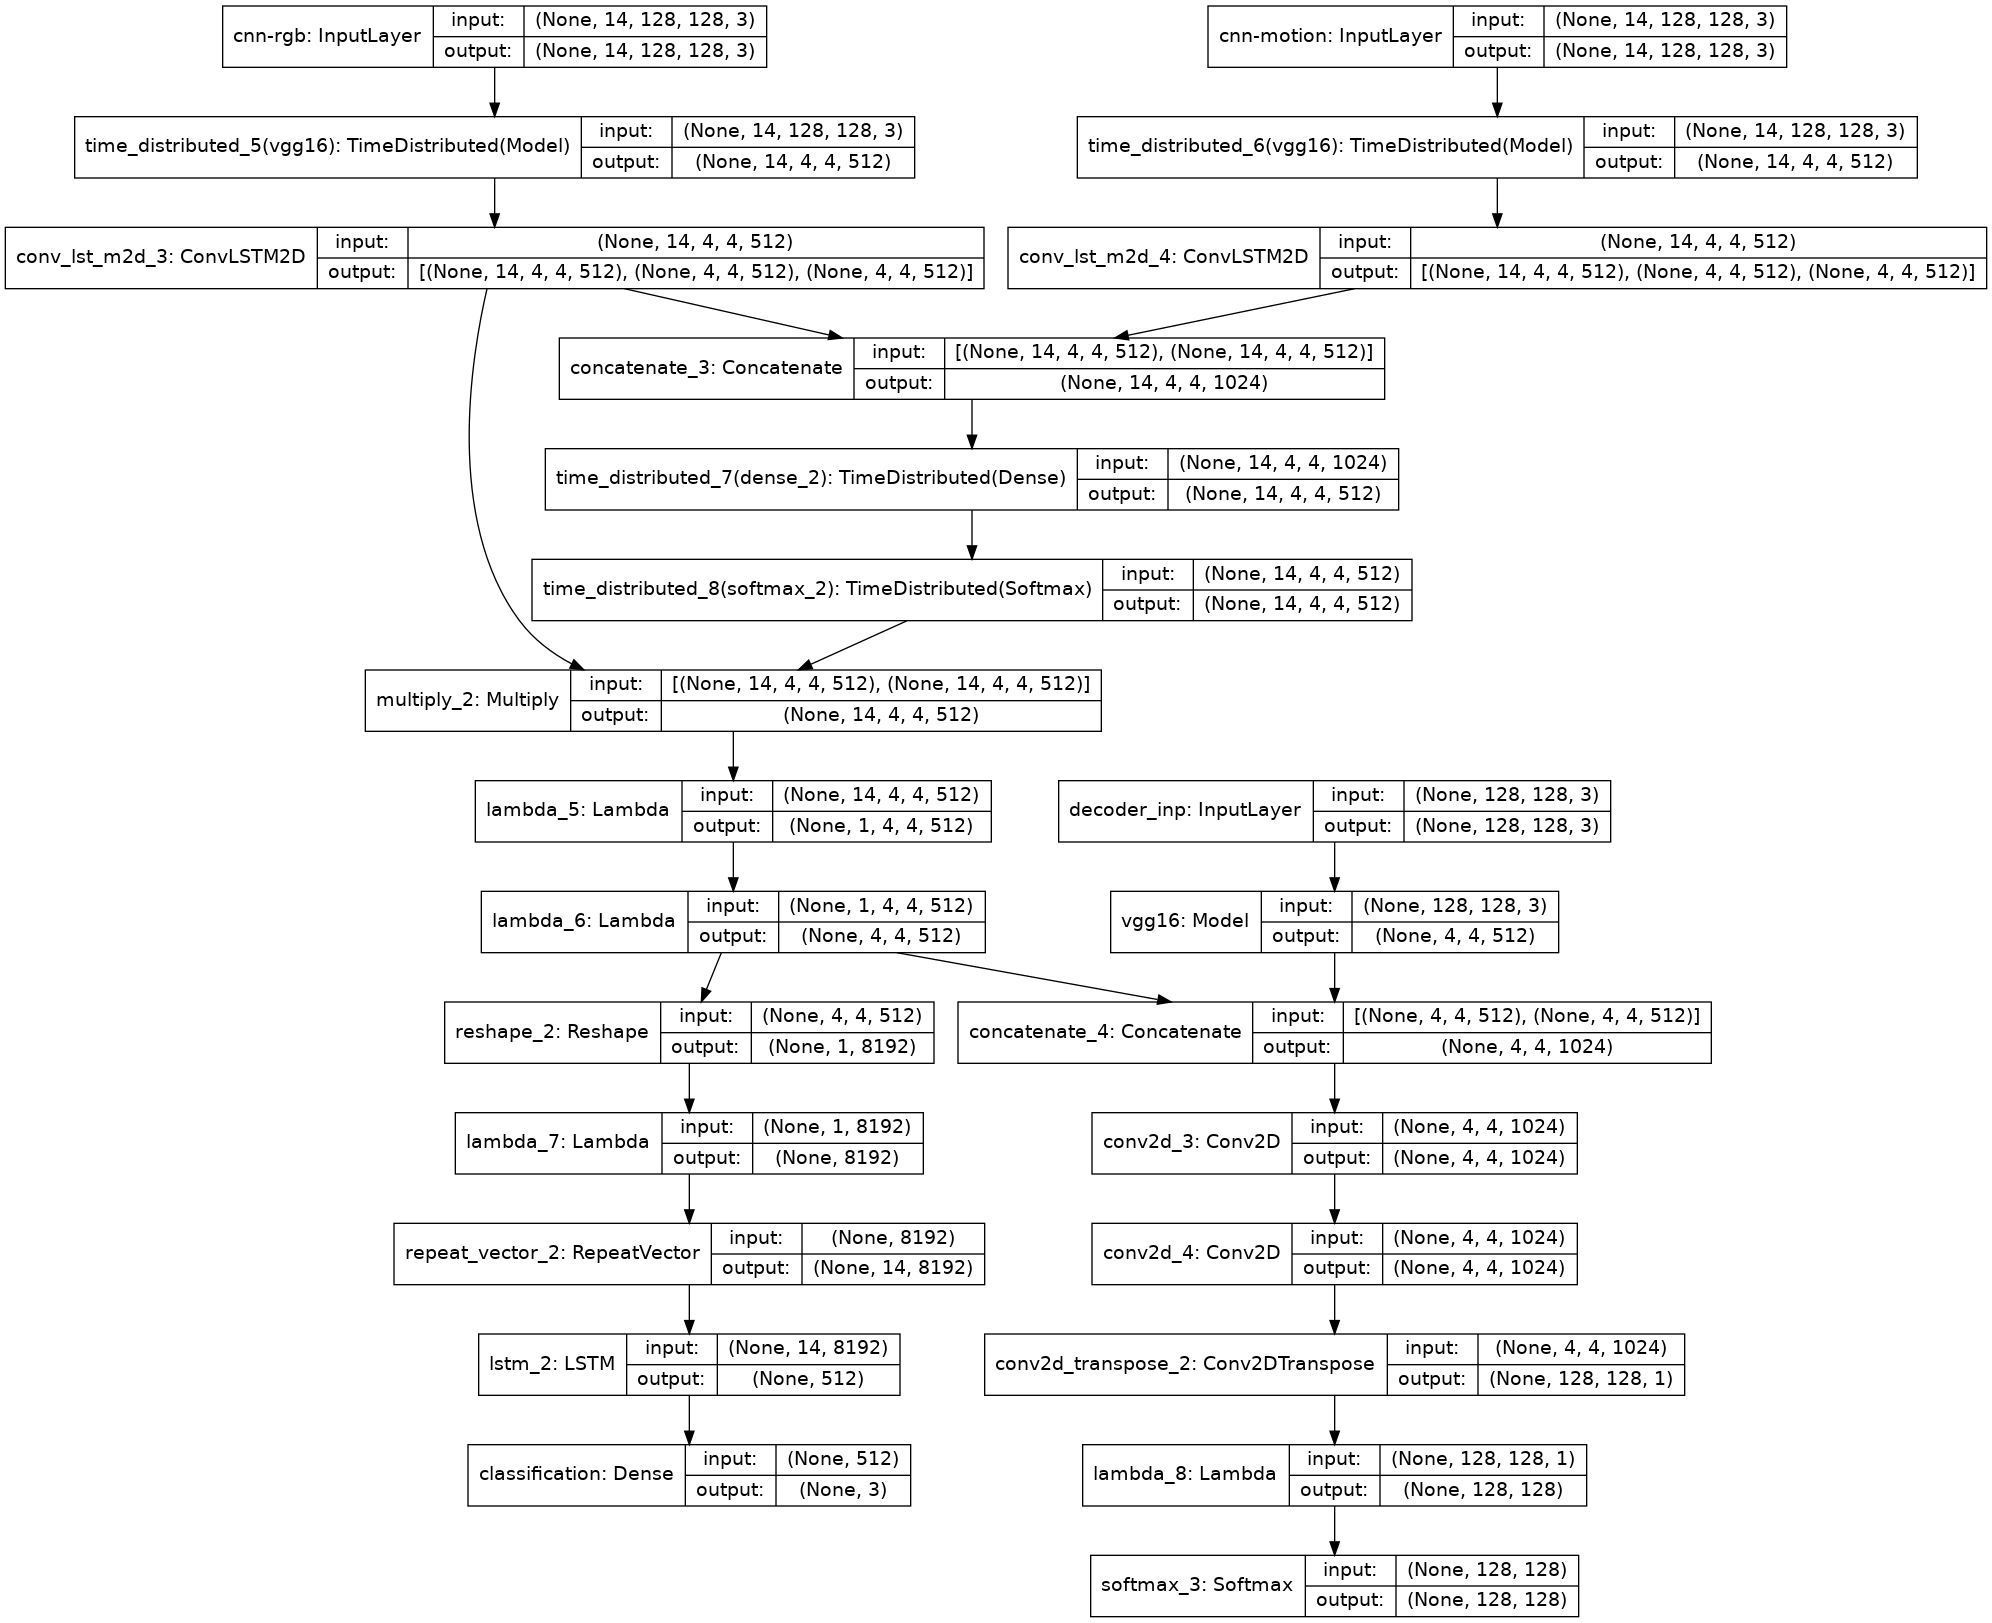

In [ ]:
import pydot
from keras.utils.vis_utils import model_to_dot
import pydotplus
keras.utils.vis_utils.pydot = pydot
plot_model(model, to_file='model.png',show_shapes=True)

In [ ]:
# Load the Dataset csv
train_data = pd.read_csv('heatmap_dataset (1).csv')
print(train_data.head)
  

<bound method NDFrame.head of                                                 Spatial  \
0     ['training/Opra_train_rgb2/21_346.6_1.5f_0001....   
1     ['training/Opra_train_rgb2/12_396.0_1.5f_0001....   
2     ['training/Opra_train_rgb2/32_402.6_1.5f_0001....   
3     ['training/Opra_train_rgb2/42_71.5_1.8f_0001.j...   
4     ['training/Opra_train_rgb2/172_636.9_2.1f_0001...   
...                                                 ...   
4828  ['training/Opra_train_rgb2/29_117.0_13.0f_0001...   
4829  ['training/Opra_train_rgb2/33_273.5_5.1f_0001....   
4830  ['training/Opra_train_rgb2/63_226.3_3.9f_0001....   
4831  ['training/Opra_train_rgb2/77_103.0_9.0f_0001....   
4832  ['training/Opra_train_rgb2/171_150.0_3.0f_0001...   

                                               Temporal  \
0     ['training/Opra_train_diff2/21_346.6_1.5d1.png...   
1     ['training/Opra_train_diff2/12_396.0_1.5d1.png...   
2     ['training/Opra_train_diff2/32_402.6_1.5d1.png...   
3     ['training/Opra_tra

In [ ]:
def resize_points(points, src_shape, dst_shape):
    """Resize the points."""
    xs = points[:, 0]
    ys = points[:, 1]
    new_xs = xs * dst_shape[0] / src_shape[0]
    new_ys = ys * dst_shape[1] / src_shape[1]
    new_points = np.hstack([new_xs[:, np.newaxis], new_ys[:, np.newaxis]])
    return new_points
    
def compute_heatmap(points, image_size, crop=None, scale=None, k_ratio=1.0):
    """Compute the heatmap from annotated points.
    Args:
        points: The annotated points.
        image_size: The size of the image.
        crop: If not None, crop the generated heatmap array.
        scale: If not None, scale the genearted heatmap array.
        k_ratio: The kernal size of Gaussian blur.
    Returns:
        The heatmap array.
    """
    heatmap = np.zeros((image_size[0], image_size[1]), dtype=np.float32)
    n_points = points.shape[0]

    for i in range(n_points):
        x = points[i, 0]
        y = points[i, 1]
        row = int(y)
        col = int(x)
        try:
            heatmap[row, col] += 1.0
        except:
            # resize pushed it out of bounds somehow
            row = min(max(row, 0), image_size[0]-1)
            col = min(max(col, 0), image_size[1]-1)
            heatmap[row, col] += 1.0
        # heatmap[row, col] += 1.0

    # Compute kernel size of the Gaussian filter. The kernel size must be odd.
    k_size = int(np.sqrt(image_size[0] * image_size[1]) / k_ratio)

    if k_size % 2 == 0:
        k_size += 1

    # Compute the heatmap using the Gaussian filter.
    heatmap = cv2.GaussianBlur(heatmap, (k_size, k_size), 0)

    if crop:
        heatmap = heatmap[crop[0]:crop[0]+crop[2], crop[1]:crop[1]+crop[3]]

    if scale:
        heatmap = cv2.resize(heatmap, None, None, fx=scale, fy=scale,
                             interpolation=cv2.INTER_LINEAR)

    heatmap /= np.sum(heatmap)

    return heatmap


In [ ]:
size = 128
new_train = pd.DataFrame(columns=['Spatial','Temporal','Image','Labels','Class'])
for i in tqdm(range(train_data.shape[0])):
  points = train_data['Points'][i]
  points = ast.literal_eval(points)
  points = np.array(points, dtype=np.float32)
  shape = train_data['Shape'][i]
  shape = ast.literal_eval(shape)
  new_points = resize_points(points,shape,(size,size))
  heatmap = compute_heatmap(new_points,(size,size),None,None,3)
  data = {'Spatial':train_data['Spatial'][i], 'Temporal':train_data['Temporal'][i],'Image':train_data['Image'][i],'Labels':heatmap,'Class':train_data['Class'][i]}
  new_train = new_train.append(data,ignore_index=True)
  
print(new_train)

100%|██████████| 4833/4833 [00:23<00:00, 205.69it/s]


                                                Spatial  \
0     ['training/Opra_train_rgb2/21_346.6_1.5f_0001....   
1     ['training/Opra_train_rgb2/12_396.0_1.5f_0001....   
2     ['training/Opra_train_rgb2/32_402.6_1.5f_0001....   
3     ['training/Opra_train_rgb2/42_71.5_1.8f_0001.j...   
4     ['training/Opra_train_rgb2/172_636.9_2.1f_0001...   
...                                                 ...   
4828  ['training/Opra_train_rgb2/29_117.0_13.0f_0001...   
4829  ['training/Opra_train_rgb2/33_273.5_5.1f_0001....   
4830  ['training/Opra_train_rgb2/63_226.3_3.9f_0001....   
4831  ['training/Opra_train_rgb2/77_103.0_9.0f_0001....   
4832  ['training/Opra_train_rgb2/171_150.0_3.0f_0001...   

                                               Temporal  \
0     ['training/Opra_train_diff2/21_346.6_1.5d1.png...   
1     ['training/Opra_train_diff2/12_396.0_1.5d1.png...   
2     ['training/Opra_train_diff2/32_402.6_1.5d1.png...   
3     ['training/Opra_train_diff2/42_71.5_1.8d1.png'...

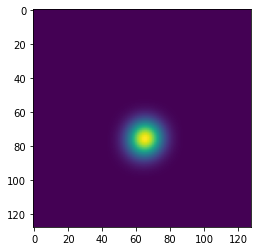

In [ ]:
plt.imshow(new_train.iloc[0]['Labels'])

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


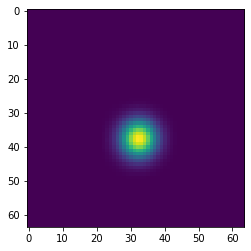

In [ ]:
import ast
points = train_data.iloc[0]['Points']
points = ast.literal_eval(points)
points = np.array(points, dtype=np.float32)
s = train_data.iloc[0]['Shape']
s = ast.literal_eval(s)
new_points = resize_points(points,(s[0],s[1]),(64,64))
heatmap= compute_heatmap(new_points,(64,64),None, None,3)
print(heatmap)
plt.imshow(heatmap)

In [ ]:
with open('test.npy', 'wb') as f:
    np.save(f, heatmap)

In [ ]:
with open('test.npy', 'rb') as f:
    a = np.load(f)

In [ ]:
print(a)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


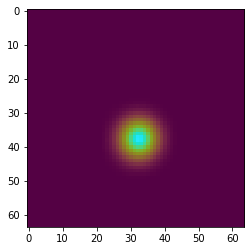

In [ ]:
im = cv2.imread('Opra_new_labels/0.png')
# print(np.amax(im))
# print(im)
plt.imshow(im)

In [ ]:
im[:,:,2]

array([[68, 68, 68, ..., 68, 68, 68],
       [68, 68, 68, ..., 68, 68, 68],
       [68, 68, 68, ..., 68, 68, 68],
       ...,
       [68, 68, 68, ..., 68, 68, 68],
       [68, 68, 68, ..., 68, 68, 68],
       [68, 68, 68, ..., 68, 68, 68]], dtype=uint8)

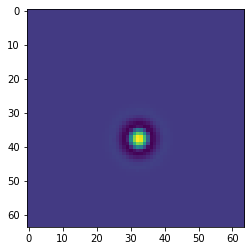

In [ ]:
plt.imshow(im[:,:,2])

In [ ]:
sub_training = pd.DataFrame(columns=['Spatial','Temporal','Image','Labels','Class'])
a,b,c,d,e,f,g = 0,0,0,0,0,0,0
training_data = new_train
# 1 - 754 , 2- 2243, 3: 408, 4-775, 5: 170, 6:369, 7:235
for i in tqdm(range(training_data.shape[0])):
  if training_data['Class'][i]==1:
    data = {'Spatial':training_data['Spatial'][i], 'Temporal':training_data['Temporal'][i],'Image':training_data['Image'][i],'Labels':training_data['Labels'][i],'Class':0}
    sub_training = sub_training.append(data,ignore_index=True)
    a += 1
  elif training_data['Class'][i]==2 and b<800:
    data = {'Spatial':training_data['Spatial'][i], 'Temporal':training_data['Temporal'][i],'Image':training_data['Image'][i],'Labels':training_data['Labels'][i], 'Class':1}
    sub_training = sub_training.append(data,ignore_index=True)
    b += 1

  # elif training_data['Class'][i]==3:
  #   data = {'Spatial':training_data['Spatial'][i], 'Temporal':training_data['Temporal'][i],'Image':training_data['Image'][i],'Labels':training_data['Labels'][i], 'Class':2}
  #   sub_training = sub_training.append(data,ignore_index=True)
  #   c += 1

  elif training_data['Class'][i]==4:
    data = {'Spatial':training_data['Spatial'][i], 'Temporal':training_data['Temporal'][i],'Image':training_data['Image'][i],'Labels':training_data['Labels'][i], 'Class':2}
    sub_training = sub_training.append(data,ignore_index=True)
    d += 1

  # elif training_data['Class'][i]==5 and e<200:
  #   data = {'Spatial':training_data['Spatial'][i], 'Temporal':training_data['Temporal'][i],'Image':training_data['Image'][i],'Labels':training_data['Labels'][i], 'Class':4}
  #   sub_training = sub_training.append(data,ignore_index=True)
  #   e += 1
  
  # elif training_data['Class'][i]==6:
  #   data = {'Spatial':training_data['Spatial'][i], 'Temporal':training_data['Temporal'][i],'Image':training_data['Image'][i],'Labels':training_data['Labels'][i], 'Class':4}
  #   sub_training = sub_training.append(data,ignore_index=True)
  #   f += 1
  
  # elif training_data['Class'][i]==7 and g<230:
  #   data = {'Spatial':training_data['Spatial'][i], 'Temporal':training_data['Temporal'][i],'Image':training_data['Image'][i],'Labels':training_data['Labels'][i], 'Class':6}
  #   sub_training = sub_training.append(data,ignore_index=True)
  #   g += 1

print(a,b,c,d,e,f,g)
  
print(sub_training)
print(sub_training.shape)

100%|██████████| 4833/4833 [00:09<00:00, 500.65it/s]


730 800 0 775 0 0 0
                                                Spatial  \
0     ['training/Opra_train_rgb2/32_402.6_1.5f_0001....   
1     ['training/Opra_train_rgb2/183_188.5_9.0f_0001...   
2     ['training/Opra_train_rgb2/14_249.5_6.5f_0001....   
3     ['training/Opra_train_rgb2/23_228.2_3.3f_0001....   
4     ['training/Opra_train_rgb2/33_189.8_9.6f_0001....   
...                                                 ...   
2300  ['training/Opra_train_rgb2/30_84.0_3.9f_0001.j...   
2301  ['training/Opra_train_rgb2/129_513.5_6.5f_0001...   
2302  ['training/Opra_train_rgb2/126_34.6_3.6f_0001....   
2303  ['training/Opra_train_rgb2/29_117.0_13.0f_0001...   
2304  ['training/Opra_train_rgb2/171_150.0_3.0f_0001...   

                                               Temporal  \
0     ['training/Opra_train_diff2/32_402.6_1.5d1.png...   
1     ['training/Opra_train_diff2/183_188.5_9.0d1.pn...   
2     ['training/Opra_train_diff2/14_249.5_6.5d1.png...   
3     ['training/Opra_train_diff2/2

In [ ]:
#Shuffle the dataset
sub_training = sub_training.sample(frac=1).reset_index(drop=True)
print(sub_training)

                                                Spatial  \
0     ['training/Opra_train_rgb2/11_165.0_6.5f_0001....   
1     ['training/Opra_train_rgb2/176_38.6_3.3f_0001....   
2     ['training/Opra_train_rgb2/121_29.0_11.6f_0001...   
3     ['training/Opra_train_rgb2/146_153.6_8.4f_0001...   
4     ['training/Opra_train_rgb2/2_88.0_2.1f_0001.jp...   
...                                                 ...   
2300  ['training/Opra_train_rgb2/116_79.7_2.7f_0001....   
2301  ['training/Opra_train_rgb2/74_289.5_2.4f_0001....   
2302  ['training/Opra_train_rgb2/60_129.1_2.4f_0001....   
2303  ['training/Opra_train_rgb2/128_44.0_3.0f_0001....   
2304  ['training/Opra_train_rgb2/122_338.9_5.7f_0001...   

                                               Temporal  \
0     ['training/Opra_train_diff2/11_165.0_6.5d1.png...   
1     ['training/Opra_train_diff2/176_38.6_3.3d1.png...   
2     ['training/Opra_train_diff2/121_29.0_11.6d1.pn...   
3     ['training/Opra_train_diff2/146_153.6_8.4d1.pn...

In [ ]:
training = sub_training.iloc[:1844,:]
validation = pd.DataFrame(columns=['Spatial','Temporal','Image','Labels','Class'])

for i in sub_training.index:
  if i >= 1844:
    data = {'Spatial':sub_training['Spatial'][i], 'Temporal':sub_training['Temporal'][i],'Image':sub_training['Image'][i],'Labels':sub_training['Labels'][i],'Class':sub_training['Class'][i]}
    validation = validation.append(data,ignore_index=True)

print(training.shape)
print(validation.shape)

(1844, 5)
(461, 5)


In [ ]:
size = 128
def data_generator(data,batch_size):              
    """
    Yields the next training batch.
    data is an array  [[[frame1_filename,frame2_filename,…frame16_filename],label1], [[frame1_filename,frame2_filename,…frame16_filename],label2],……….].
    """
   
    num_samples = len(data)
    while True:   
        for offset in range(0, num_samples, batch_size):
            print ('startring index: ', offset) 
            # Get the samples you'll use in this batch
            batch_samples = data[offset:offset+batch_size]
            
            # Initialise X_train and y_train arrays for this batch
            X_train_rgb = []
            X_train_diff = []
            X_images = []

            y_train = []
            y_images = []
            # For each example
            for b in range(batch_samples.shape[0]):
                # Load image (X)
                b = b+offset
                
                # print(batch_samples)
                x_rgb = batch_samples['Spatial'][b]
                x_rgb = ast.literal_eval(x_rgb)
                
                x_diff = batch_samples['Temporal'][b]
                x_diff = ast.literal_eval(x_diff)

                image=batch_samples['Image'][b]
                inp = cv2.imread(image)
                inp_image = cv2.resize(inp,(size,size))
                X_images.append(inp_image)

                # get the ground truth heatmap
                h = batch_samples['Labels'][b]
                # h = ast.literal_eval(h)              
                y_images.append(h)

                # Read label (y)
                y = batch_samples['Class'][b]
                y_train.append(y)

                temp_data_rgb = []
                for img in x_rgb:
                  try:
                        img = cv2.imread(img)
                        img = cv2.resize(img,(size,size))
                        temp_data_rgb.append(img)
                  except Exception as e:
                        print (e)
                        print ('error reading file: ',img)                      
                X_train_rgb.append(temp_data_rgb[1:]) 

                temp_data_diff = []
                for img in x_diff:
                  try:
                        img = cv2.imread(img)
                        #apply any kind of preprocessing here
                        img = cv2.resize(img,(size,size))
                        temp_data_diff.append(img)
                  except Exception as e:
                        print (e)
                        print ('error reading file: ',img)                      
                X_train_diff.append(temp_data_diff)
                
            # Make sure they're numpy arrays (as opposed to lists)
            X_train_rgb = np.array(X_train_rgb)
            X_train_diff = np.array(X_train_diff)
            X_images = np.array(X_images)
            
            y_train = np.array(y_train)
            # create one hot encoding for training in keras
            y_train = np_utils.to_categorical(y_train, 3)
            
            y_images = np.array(y_images)
            # y_images = np.expand_dims(y_images,axis=-1)
            y = np.array(y)
            y = np_utils.to_categorical(y_train, 3)
            # yield the next training batch            
            # yield [X_train_rgb,X_train_diff,X_images], [y_train,y_images]
            yield y
      

In [ ]:
test = data_generator(validation,461)
y_true = next(test)

print(len(y_true))

startring index:  0
461


In [ ]:
print(y_true)

In [ ]:
train = data_generator(training,12)
val = data_generator(validation,12)
# X,y = next(train_test)
# print(X[0].shape,X[1].shape,X[2].shape)
# print(y.shape)
# print(y[0].shape,y[1].shape)
# y = np.squeeze(y,axis=0)
# y = np.squeeze(y,axis=-1)
# plt.imshow(y[1][8])
# print(y[1][9])
# callbacks=[EarlyStopping(monitor='val_loss',  mode='auto', verbose=1, patience=5)]

In [ ]:
from keras.callbacks import ModelCheckpoint
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath='3classes_loss.h5',
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

In [ ]:
batch_size = 12
model.fit(train,
          steps_per_epoch=len(training)//batch_size,
          epochs = 50,
          verbose = 1,
          validation_data=val,
          validation_steps=len(validation)//batch_size)
# model1.save('3classes.h5')

Streaming output truncated to the last 5000 lines.
  8/153 [>.............................] - ETA: 1:43 - loss: 1.2351 - classification_loss: 1.1652 - softmax_3_loss: 0.0700 - classification_accuracy: 0.3438 - classification_mean_squared_error: 0.2366 - softmax_3_accuracy: 0.0035 - softmax_3_mean_squared_error: 0.0078startring index:  1788
startring index:  300
152/153 [============================>.] - ETA: 0s - loss: 1.2257 - classification_loss: 1.1558 - softmax_3_loss: 0.0699 - classification_accuracy: 0.3385 - classification_mean_squared_error: 0.2340 - softmax_3_accuracy: 0.0044 - softmax_3_mean_squared_error: 0.0078startring index:  1668
startring index:  312
startring index:  324
startring index:  336
startring index:  348
startring index:  360
startring index:  372
startring index:  384
startring index:  396
startring index:  408
startring index:  420
startring index:  432
startring index:  444
startring index:  456
startring index:  0
startring index:  12
startring index:  24

In [ ]:
model.save('3classes_last.h5')
# model.save('5classes.h5')

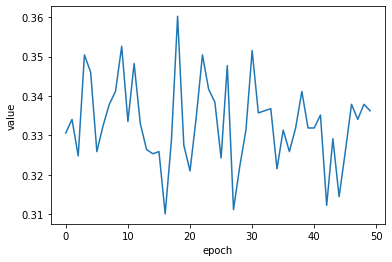

In [ ]:
# plt.plot(model.history.history['val_classification_mean_squared_error'])
plt.plot(model.history.history['classification_accuracy'])
# plt.plot(model.history.history['val_classification_accuracy'])
# plt.title('model loss')
plt.ylabel('value')
plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
model.evaluate(val,steps=len(validation)//20)

startring index:  0
startring index:  12
23/23 [==============================] - 15s 644ms/step


[1.2131056785583496,
 1.121820092201233,
 0.06997926533222198,
 0.37318840622901917,
 0.2268967628479004,
 0.00467051612213254,
 0.007811294868588448]

In [ ]:
from keras.models import load_model

new_model = load_model('3classes_last.h5', custom_objects={'tf': tf})
new_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
cnn-rgb (InputLayer)            (None, 14, 128, 128, 0                                            
__________________________________________________________________________________________________
cnn-motion (InputLayer)         (None, 14, 128, 128, 0                                            
__________________________________________________________________________________________________
time_distributed_5 (TimeDistrib (None, 14, 4, 4, 512 14714688    cnn-rgb[0][0]                    
__________________________________________________________________________________________________
time_distributed_6 (TimeDistrib (None, 14, 4, 4, 512 14714688    cnn-motion[0][0]                 
____________________________________________________________________________________________

In [ ]:
y_pred=new_model.predict(val,steps=len(validation)//12)

In [ ]:
con_mat = tf.math.confusion_matrix(labels=y_true, predictions=y_pred).numpy()

In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
new_model.compile(optimizer=opt,
              loss = ['categorical_crossentropy',keras.losses.KLDivergence()],
              metrics=['accuracy','mean_squared_error'])

In [ ]:
model.evaluate(val,steps=len(validation)//12)

data/images/seattle/1/45/AR72L0JX4D03W_2.jpg 2


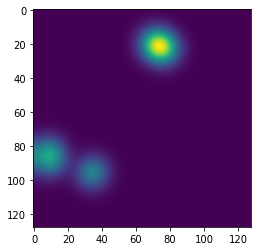

In [ ]:
import ast
num = 777
# 4, 10, 0
# sub-333,777
# class - sub-777,891,34,567,78
# 777
# corr- 3 - 20, 2300, 
train=sub_training
rgb_frames = train.iloc[num]['Spatial']
rgb_frames = ast.literal_eval(rgb_frames)
diff_frames = train.iloc[num]['Temporal']
diff_frames = ast.literal_eval(diff_frames)
image = train.iloc[num]['Image']
# labeled = train_data.iloc[0]['Points']
action = train.iloc[num]['Class']
print(image,action)
# print(sub_training.iloc[1010]['Labels'].shape)
plt.imshow(train.iloc[num]['Labels'])

In [ ]:
temp_data_list = []
rgb = []
diff = []
temp_diff = []
img_np = []
for img in rgb_frames[1:]:
  img = cv2.imread(img)  
  img = cv2.resize(img,(128,128))
  temp_data_list.append(img)
rgb.append(temp_data_list)

rgb = np.array(rgb)
for img in diff_frames:
  img = cv2.imread(img)
  img = cv2.resize(img,(128,128))
  temp_diff.append(img)
diff.append(temp_diff)
diff = np.array(diff)
x_img = cv2.imread(image)
x_img = cv2.resize(x_img,(128,128))
img_np.append(x_img)
img_np = np.array(img_np)
print(rgb.shape,diff.shape,img_np.shape)
# print(type(rgb))
# model.predict([rgb,diff,img_np])

(1, 14, 128, 128, 3) (1, 14, 128, 128, 3) (1, 128, 128, 3)


In [ ]:
prediction= new_model.predict([rgb,diff,img_np])
# print(prediction_1.shape)
# prediction_1 = np.squeeze(prediction_1,axis=0)
# # prediction_1 = np.squeeze(prediction_1,axis=-1)
# print(np.amin(prediction))
# plt.imshow(prediction_1/255)
# print(prediction_1)

In [ ]:
action_labels = {0: 'hold', 1: 'touch', 2: 'push'}
# np.array(prediction, dtype='float32')

In [ ]:
print(prediction[0])
ind = np.argmax(prediction[0], axis=1)
print(action_labels[ind[0]])

[[0.3219303  0.3171802  0.36088955]]
push


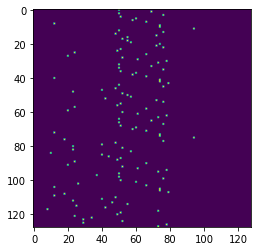

In [ ]:
prediction[1] = np.squeeze(prediction[1],axis=0)
plt.imshow(prediction[1])
# prediction.shape
# print(prediction)

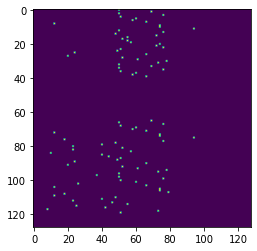

In [ ]:
# pred = copy.deepcopy(prediction[1])

In [ ]:
im = cv2.imread(image)
img = cv2.imread(image)
points = train_data.iloc[num]['Points']
points = ast.literal_eval(points)
points = np.array(points, dtype=np.float32)
s = train_data.iloc[num]['Shape']
s = ast.literal_eval(s)
# new_points = resize_points(points,(s[0],s[1]),(128,128))
heatmap= compute_heatmap(points,s,None,None,3)
im = cv2.resize(im,s)
img = cv2.resize(img,(128,128))
# plt.imshow(im)

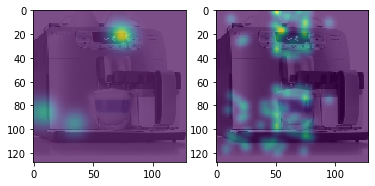

In [ ]:
h = cv2.GaussianBlur(pred,(43, 43), 3.0)
plt.figure()
plt.subplot(1,2,1)
plt.imshow(x_img, 'gray', interpolation='none',alpha=0.7)
plt.imshow(sub_training.iloc[num]['Labels'],interpolation='none',alpha=0.7)
plt.subplot(1,2,2)
plt.imshow(x_img,'gray',interpolation='none')
plt.imshow(h, interpolation='none', alpha=0.7)
plt.show()

In [ ]:
print(sub_training.iloc[num]['Labels'])

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [ ]:
from astropy.convolution.kernels import Gaussian2DKernel
from astropy.convolution import convolve
fig, (ax1, ax2) = plt.subplots(1, 2)
# ax1.imshow(prediction_155)
plt.imshow(convolve(prediction_155, Gaussian2DKernel(stddev=2)), interpolation='none')
# plt.show()

In [ ]:
import copy
from skimage.metrics import structural_similarity
# prediction_1010[1] = np.squeeze(prediction_1010[1],axis=0)
prediction[1] = np.expand_dims(prediction[1],axis=-1)
gt = copy.deepcopy(sub_training.iloc[0]['Labels'])
gt = np.expand_dims(gt,axis=-1)
print(gt.shape,prediction[1].shape)
ssim_score = structural_similarity(gt, prediction[1], multichannel=True)
print(ssim_score)

(128, 128, 1) (128, 128, 1)
0.7009741573742202


In [ ]:
print(prediction_1010[0])

[[0.2231965  0.33450103 0.4423025 ]]


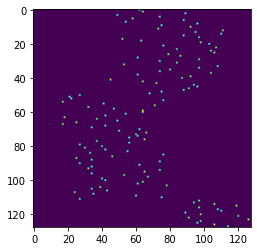

In [ ]:
# prediction_1010[1] = np.squeeze(prediction_1010[1],axis=0)
plt.imshow(prediction_1010[1])

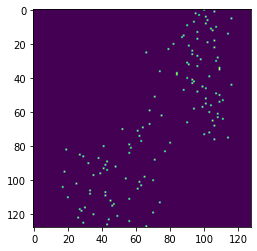

In [ ]:
plt.imshow(prediction[1])

In [ ]:
import numpy as np
from PIL import Image
print(prediction_1.shape)
print(np.count_nonzero(prediction))
prediction = np.squeeze(prediction_1, axis = 0) 
def numpy2pil(np_array: np.ndarray) -> Image:
    """
    Convert an HxWx3 numpy array into an RGB Image
    """

    assert_msg = 'Input shall be a HxWx3 ndarray'
    assert isinstance(np_array, np.ndarray), assert_msg
    assert len(np_array.shape) == 3, assert_msg
    assert np_array.shape[2] == 3, assert_msg

    img = Image.fromarray(np_array, 'RGB')
    return img

# slice56 = np.random.random((226, 226))
# plt.subplot(550)
plt.imshow(prediction)